<a href="https://colab.research.google.com/github/srdebayan/sentiment_analysis_neuralNetwork/blob/main/ML_mini_proj_2_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This workbook is a NLP program which takes the tweet data and then creates two models- A sequential neural network and one convolution neural network to do the sentiment analysis. We can compare the performance of the two models here aswell. There are techniques which are used in processing the tweets aswell. 

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
#our dataset file is stored in this location
url = 'https://raw.githubusercontent.com/srdebayan/sentiment_analysis_neuralNetwork/main/Sentiment140.tenPercent.sample.tweets.tsv'
tweets_df = pd.read_table(url)
# Dataset is now stored in a Pandas Dataframe

tweets_df.isnull().values.any()

tweets_df.shape

(160000, 2)

In [3]:
#checking the tweets
tweets_df.head(5)

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [4]:
tweets_df["tweet_text"][3]

'@vaLewee I know!  Saw it on the news!'

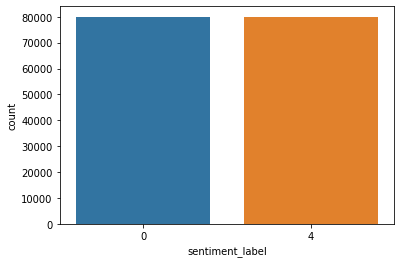

In [5]:
#checking the balance of the data, it is equally balanced
import seaborn as sns

sns.countplot(x='sentiment_label', data=tweets_df)

We will now process the tweets. We will clean the text so that it can be transformed easily.

In [6]:
tweets_df['tweet_text']=tweets_df['tweet_text'].str.lower()
#tweets_df['tweet_text'].tail()
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
# Removing Stopwords

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweets_df['tweet_text'] = tweets_df['tweet_text'].apply(lambda text: cleaning_stopwords(text))
tweets_df['tweet_text'].tail()
# removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
tweets_df['tweet_text'] = tweets_df['tweet_text'].apply(lambda x: cleaning_URLs(x))
tweets_df['tweet_text'].head()
# removing numbers 

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
tweets_df['tweet_text'] = tweets_df['tweet_text'].apply(lambda x: cleaning_numbers(x))
tweets_df['tweet_text'].head()
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt
# remove twitter handles (@user)

tweets_df['tweet_text'] = np.vectorize(remove_pattern)(tweets_df['tweet_text'], "@[\w]*")
tweets_df.head()
# remove special characters, numbers and punctuations

tweets_df['tweet_text'] = tweets_df['tweet_text'].str.replace("[^a-zA-Z#]", " ")
tweets_df.head()
# remove short words

tweets_df['tweet_text'] = tweets_df['tweet_text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
tweets_df.head()


<ipython-input-6-6e9cfadf44d3>:51: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['tweet_text'] = tweets_df['tweet_text'].str.replace("[^a-zA-Z#]", " ")


,sentiment_label,tweet_text
0,4,dear happy friday already rice bowl lunch
1,4,ughhh layin downnnn waiting zeina cook breakfast
2,0,reckon play even know nothing without
3,0,know news
4,0,down services used over years


In [7]:
X = []
text = list(tweets_df['tweet_text'])
for tx in text:
    X.append(tx)
X[3]    

'know news'

In [8]:
y = tweets_df['sentiment_label']
y[1]

4

In [9]:
#converting the labels of the sentiment to 1 or 0
y = tweets_df['sentiment_label']

y = np.array(list(map(lambda x: 1 if x==4 else 0, y)))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
y_train

array([1, 1, 1, ..., 0, 1, 1])

In [12]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
from google.colab import files

In [13]:


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Sequential neural network

In [16]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
#model.add(Dense(1, activation='sigmoid'))

model.add(Dense(16, input_dim=2, activation='relu', name= 'input'))
model.add(Dense(32, activation='relu', name= 'hidden_1'))
model.add(Dense(64, activation='relu', name= 'hidden_2'))
model.add(Dense(128, activation='relu', name= 'hidden_3'))
model.add(Dense(256,  activation='relu', name= 'hidden_4'))
#model.add(Dense(512, activation='relu', name= 'hidden_5'))
#model.add(Dense(1028, activation='relu', name= 'hidden_6'))
#model.add(Dense(2056, activation='relu', name= 'hidden_7'))
model.add(Dense(1, input_dim=2, activation='sigmoid', name= 'output'))

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5559800   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 input (Dense)               (None, 16)                160016    
                                                                 
 hidden_1 (Dense)            (None, 32)                544       
                                                                 
 hidden_2 (Dense)            (None, 64)                2112      
                                                                 
 hidden_3 (Dense)            (None, 128)               8320      
                                                                 
 hidden_4 (Dense)            (None, 256)               3

In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
800/800 [==============================] - 14s 16ms/step - loss: 0.5989 - acc: 0.6728 - val_loss: 0.5892 - val_acc: 0.6810
Epoch 2/10
800/800 [==============================] - 12s 16ms/step - loss: 0.5735 - acc: 0.6957 - val_loss: 0.5847 - val_acc: 0.6910
Epoch 3/10
800/800 [==============================] - 12s 15ms/step - loss: 0.5622 - acc: 0.7042 - val_loss: 0.5765 - val_acc: 0.6968
Epoch 4/10
800/800 [==============================] - 11s 14ms/step - loss: 0.5515 - acc: 0.7124 - val_loss: 0.5853 - val_acc: 0.6903
Epoch 5/10
800/800 [==============================] - 11s 14ms/step - loss: 0.5418 - acc: 0.7206 - val_loss: 0.5840 - val_acc: 0.6923
Epoch 6/10
800/800 [==============================] - 13s 17ms/step - loss: 0.5325 - acc: 0.7282 - val_loss: 0.5866 - val_acc: 0.6934
Epoch 7/10
800/800 [==============================] - 12s 15ms/step - loss: 0.5242 - acc: 0.7326 - val_loss: 0.5994 - val_acc: 0.6923
Epoch 8/10
800/800 [==============================] - 12s 15ms

In [19]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 4s 4ms/step - loss: 0.6104 - acc: 0.6868


In [20]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6103923320770264
Test Accuracy: 0.686843752861023


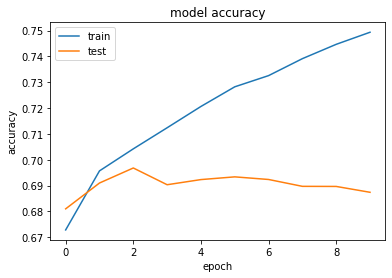

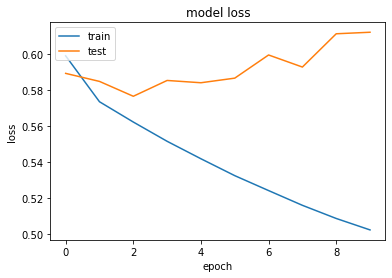

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**CNN**

In [22]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5559800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,624,057
Trainable params: 64,257
Non-trainable params: 5,559,800
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
800/800 [==============================] - 101s 126ms/step - loss: 0.5731 - acc: 0.6982 - val_loss: 0.5556 - val_acc: 0.7140
Epoch 2/10
800/800 [==============================] - 97s 121ms/step - loss: 0.5283 - acc: 0.7334 - val_loss: 0.5498 - val_acc: 0.7200
Epoch 3/10
800/800 [==============================] - 93s 116ms/step - loss: 0.5026 - acc: 0.7512 - val_loss: 0.5532 - val_acc: 0.7172
Epoch 4/10
800/800 [==============================] - 94s 118ms/step - loss: 0.4755 - acc: 0.7698 - val_loss: 0.5632 - val_acc: 0.7159
Epoch 5/10
800/800 [==============================] - 98s 122ms/step - loss: 0.4502 - acc: 0.7856 - val_loss: 0.5729 - val_acc: 0.7151
Epoch 6/10
800/800 [==============================] - 90s 113ms/step - loss: 0.4269 - acc: 0.8000 - val_loss: 0.5865 - val_acc: 0.7127
Epoch 7/10
800/800 [==============================] - 92s 115ms/step - loss: 0.4040 - acc: 0.8127 - val_loss: 0.6072 - val_acc: 0.7082
Epoch 8/10
800/800 [==============================] - 

In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6532533168792725
Test Accuracy: 0.7049687504768372


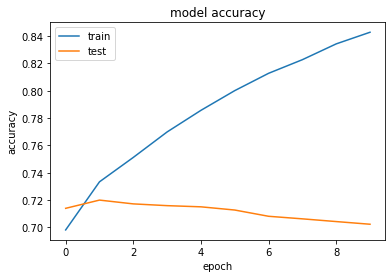

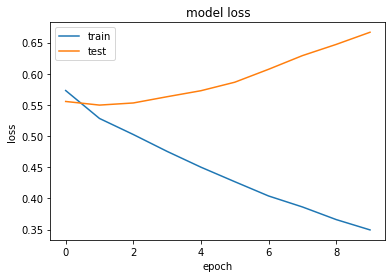

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()